### **Práctica 2 - Machine Learning III**

**Objetivo**: 
1. Analizar el conjunto de datos. 
2. Crear un sistema de recomendación de artistas para usuarios.
   
**Entregar**: Este cuaderno de jupyter con el trabajo hecho y comentado.

**Datos**: 

Los datos suministrados ya han sido procesados, limpiados y estructurados para simplificar su manejo y análisis. 

Para aquellos interesados en explorar y manipular el conjunto de datos original, así como entender la estructura, podéis descargarlo directamente aquí: 

https://grouplens.org/datasets/hetrec-2011/.

In [1]:
### ARCHIVOS DE DATOS DISPONIBLES: 
#1. artists.dat: info de los artistas que escuchan y etiquetan (tag) los users
#2. tags.dat: info de los tags que se pueden asignar a los artistas
#3. user_artists.dat: info de los artistas que escuchan los usuarios
#4. user_friends.dat: info de los amigos de los usuarios
#5. user_taggedartists.dat: tags que los usuarios asignan a los artistas
#6. user_taggedartists-timestamps.dat: igual que el anterior pero con timestamps

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
artists = pd.read_csv('./hetrec2011-lastfm-2k/artists-v2.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./hetrec2011-lastfm-2k/user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('hetrec2011-lastfm-2k/tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',header=0, sep='\t')


In [3]:
#Info artistas
artists.head()

,artistID,name,freq,listeners
0,89,Lady Gaga,611,3798959
1,289,Britney Spears,522,3243214
2,288,Rihanna,484,4542147
3,227,The Beatles,480,3658694
4,300,Katy Perry,473,3721531


In [8]:
#artistas escuchados por cada usuario. 
### Sobre weight: 
#listening count para cada [user,artist] pair.
# imaginamos que serán los minutos.
#Podemos utilizarlo como rating, más minutos, más le gusta.

users.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [ ]:
#Tag que el usuario asigna a un artista, y en el momento en el que se lo asignó.
user_tag_artist.head()


In [ ]:
#POSIBLES TAGS QUE SE PUEDEN ASIGNAR:
print("\nInformación de etiquetas:")
print(tags.head())


In [ ]:
artists.info()

In [ ]:
# No hay nulos en el fichero de artistas
artists.isna().sum()

In [ ]:
users.info()

In [ ]:
users.isna().sum()

In [ ]:
#Artistas con más listeners.
artists.sort_values(by='listeners', ascending=False).head(10)

Aunque en este ejercicio no se vaya a utilizar, es interesante conocer las etiquetas que más se usan para futuras aplicaciones de este sistema de recomendacion

In [ ]:
# Contar la frecuencia de aparición de las etiquetas
tag_counts = user_tag_artist['tagID'].value_counts().sort_values(ascending=False)[:10]
top_tags = tags.loc[tag_counts.index]['tagValue']

plt.barh(top_tags, tag_counts)
plt.xlabel('Número de veces que la etiqueta fue utilizada')
plt.ylabel('Etiqueta')
plt.title('Top 10 etiquetas más utilizadas')
plt.gca().invert_yaxis()
plt.show()




In [ ]:
users.value_counts('weight', normalize = False)

In [ ]:
#Boxplot de la variable weight 
plt.boxplot(users['weight'])

In [ ]:
len(users)

In [ ]:
#Outliers: consideramos outliers los puntos que estén 3 desviaciones estándar por encima de la media.
media = users['weight'].mean()
std = users['weight'].std()
outliers = users[users['weight'] > media + 3*std]

#Porcentaje de outliers respecto al total de datos
out_prop= len(outliers)/len(users)*100
print("Los outliers representan el", out_prop, "% de los datos")

In [ ]:
from matplotlib.cbook import boxplot_stats

def explore_outliers(df, num_vars):
    outliers_df = dict()
    for k in range(len(num_vars)):
        var = num_vars[k]
        sns.boxplot(df, x=var)
        outliers_df[var] = boxplot_stats(df[var])[0]["fliers"]
        out_pos = np.where(df[var].isin(outliers_df[var]))[0].tolist() 
        out_idx = [df[var].index.tolist()[ k ] for k in out_pos]
        outliers_df[var] = {"values": outliers_df[var], 
                            "positions": out_pos, 
                            "indices": out_idx}
    return outliers_df

In [ ]:
out_XTR = explore_outliers(users, ['weight'])

In [ ]:
print('Percetage of outliers', len(out_XTR.get('weight').get('indices'))/len(users))

Contruccion de la matriz de ratings

In [ ]:
ratings_matrix = users.pivot_table(values='weight', index='userID', columns='artistID')
ratings_matrix.head()

In [ ]:
df = ratings_matrix
df['Mean weight'] = df.mean(axis=1)
sns.histplot(x='Mean weight', binwidth=0.5, data=df)

Comentario:Se decidió no eliminar los outliers ya que representaban un porcentaje muy pequeño del total. Queremos mantener los weights que son "outliers" para capturar el comportamiento de aquellos que se desvian de la tendencia principal 

### PLANTEAMIENTO DEL PROBLEMA: 
- Problema: Lo que queremos es proporcionar recomendaciones de artistas nuevos a un usuario. 
- Es un problema implícito ya que no tenemos ratings/calificaciones explícitas como tal, si no que tenemos el número de minutos escuchados.

#### User-based collaborative filtering: 
- Solución: Buscar usuarios que sean similares al usuario target para poder hacer las recomendaciones. 

- Vamos a utilizar la matriz de usuarios-artistas (Sería la matriz de ratings): 
    - Dimensiones: (mxn), m usuarios, n artistas.
    - Cada fila de la matriz es un usuario y cada columna es un artista.
    - Cada celda es el número de veces/minutos que el usuario escuchó al artista (weight)

- Cómo calcular la similitud entre usuarios? 
    - Utilizando similitud del coseno 
    - Utilizando fórmula de Pearson

- Cuando tengamos los k usuarios más similares a nuestro usuario target u (Basado en similitud)
    - Para los artistas que u no ha escuchado crearemos un rating basado en lo que los k usuarios calificaron ponderado por su peso (similitud)
    - Ordenamos por rating descendente y hacemos top-n recomendaciones. 


In [ ]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

Vamos a empezar haciendo un merge para tener en el mismo df los ususarios con los el id del artista que más escuchan pero tambien el nombre del mismo y el peso, que lo tomaremos como el "rating"

In [4]:
# Merge users and artist datasets
df = pd.merge(users, artists, on='artistID', how='inner')

# Take a look at the data
df.head()

,userID,artistID,weight,name,freq,listeners
0,2,51,13883,Duran Duran,111,1588349
1,4,51,228,Duran Duran,111,1588349
2,27,51,85,Duran Duran,111,1588349
3,28,51,10,Duran Duran,111,1588349
4,62,51,528,Duran Duran,111,1588349


In [5]:
df_drop = df.drop(columns=['freq', 'name', 'listeners'])
df_drop.head()

,userID,artistID,weight
0,2,51,13883
1,4,51,228
2,27,51,85
3,28,51,10
4,62,51,528


In [ ]:
df['weight'].mean()

In [ ]:
# Aggregate by artist
agg_ratings = df.groupby('name').agg(mean_rating = ('weight', 'mean'),
                                                number_of_ratings = ('weight', 'count')).reset_index()

In [ ]:
# Artistas que han sido escuchados por más usuarios distintos. (Más ratings)
agg_ratings.sort_values(by='number_of_ratings', ascending=False).head(10)

In [ ]:
agg_ratings.info()

mean_rating seria la media del peso que se le da a cada artista

In [ ]:
# Keep the artist with over 100 ratings (100 Listeners)
# Tenemos 125 artistas.
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

In [ ]:
# Visualization
# Relación entre el rating medio y el número de ratings de cada artista.
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [ ]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['name']], on='name', how='inner')
df_GT100.info()

In [ ]:
# Number of artists
print('The ratings dataset has', df_GT100['artistID'].nunique(), 'unique artists')

# Number of users
print('The ratings dataset has', df_GT100['userID'].nunique(), 'unique users')

# Average of weights
average_weight = df_GT100['weight'].mean()
print('The average weight is', average_weight)

# Median of weights
median_weight = df_GT100['weight'].median()
print('The median weight is', median_weight)

# Standard deviation of weights
std_weight = df_GT100['weight'].std()
print('The standard deviation of weights is', std_weight)


In [ ]:
# Create user-item matrix 
# No hay user 1 o sea que está bien. 
matrix = df_GT100.pivot_table(index='userID', columns='name', values='weight')
matrix.head()

In [ ]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

In [ ]:
# User similarity matrix using Pearson correlation
user_similarity_pearson = matrix_norm.T.corr()
user_similarity_pearson.head()

In [ ]:
# User similarity matrix using cosine similarity.
# Rellenamos con 0s los Nans porque coseno no deja. 
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

In [ ]:
# Pick a user ID
picked_userid = 2

# Remove picked user ID from the candidate list
user_similarity_pearson.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity_pearson.head()

In [ ]:
# most similar users 
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity_pearson[user_similarity_pearson[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

we will narrow down the item pool by doing the following:
1. Remove the artists that have been listened by the target user (user ID 1 in this example).
2. Keep only the artists that similar users have listened.

To remove the artists listened by the target user, we keep only the row for `userId=2` in the user-item matrix and remove the items with missing values.

In [ ]:
# artists that the target user has listened to
picked_userid_listened = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_listened

To keep only the similar users' movies, we keep the user IDs in the top 10 similar user lists and remove the film with all missing values. All missing value for a movie means that none of the similar users have watched the movie.


In [ ]:
# Artists that similar users listened. Remove artists that none of the similar users have watched
similar_user_artists = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_artists

In [ ]:
# Remove the already listened artists from the movie list
similar_user_artists.drop(picked_userid_listened.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_artists

In [ ]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_artists.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_artists[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['artist', 'artist_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='artist_score', ascending=False)

# Select top m artists
m = 10
ranked_item_score.head(m)

predict score 

In [ ]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

In [ ]:
# Calcuate the predicted rating: 
ranked_item_score['predicted_rating'] = ranked_item_score['artist_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

Voy a hacer user-based como en amazon beuty

In [6]:
import tqdm as notebook_tqdm
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN, SVD

/usr/local/Caskroom/miniforge/base/envs/envml3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def userknn_cornac(df:pd.DataFrame):

  df = df.astype({'userID':object, 'artistID':object})
  records = df.to_records(index=False)
  result = list(records)

  K = 3  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  uknn_cosine = UserKNN(k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE)
  uknn_cosine_mc = UserKNN(k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE)
  uknn_pearson = UserKNN(k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE)
  uknn_pearson_mc = UserKNN(k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE)
  
  # Metrics
  rec_300 = cornac.metrics.Recall(k=300)
  rec_900 = cornac.metrics.Recall(k=900)
  prec_30 = cornac.metrics.Precision(k=30)
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()
  
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
                    metrics=[rec_300, rec_900, prec_30, rmse, mae],
                    ).run()
  
  userknn_models = {'uknn_cosine': uknn_cosine, 'uknn_cosine_mc': uknn_cosine_mc,
                'uknn_pearson': uknn_pearson, 'uknn_pearson_mc': uknn_pearson_mc}
  
  return userknn_models

userknn_models = userknn_cornac(df_drop)


TEST:
...
                   |      MAE |      RMSE | Precision@30 | Recall@300 | Recall@900 | Train (s) | Test (s)
------------------ + -------- + --------- + ------------ + ---------- + ---------- + --------- + --------
UserKNN-Cosine     | 915.5369 | 1346.2956 |       0.0025 |     0.1086 |     0.2413 |    0.2854 |  17.9417
UserKNN-Cosine-MC  | 929.0477 | 1342.4409 |       0.0022 |     0.0763 |     0.2053 |    0.2247 |  17.4457
UserKNN-Pearson    | 929.0477 | 1342.4409 |       0.0022 |     0.0763 |     0.2053 |    0.2260 |  18.0013
UserKNN-Pearson-MC | 929.0477 | 1342.4409 |       0.0022 |     0.0763 |     0.2053 |    0.2475 |  17.0703



In [18]:
df_user_10k = users.set_index("userID")
df_item_10k = users.set_index("artistID")

In [23]:
df_user_10k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92834 entries, 1642 to 1004
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   artistID  92834 non-null  int64
 1   weight    92834 non-null  int64
dtypes: int64(2)
memory usage: 2.1 MB


array([[<Axes: title={'center': 'artistID'}>,
        <Axes: title={'center': 'weight'}>]], dtype=object)

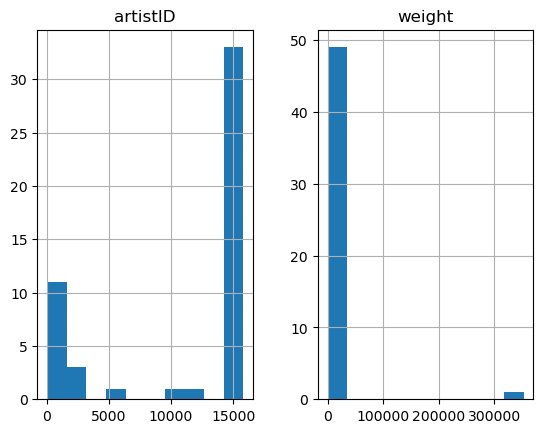

In [25]:
#localizar al usuario con userID igual a un integer 1642:
df_user_10k.loc[1642].hist()


In [26]:
df_item_10k.head()

,userID,weight
artistID,,
72,1642,352698
792,2071,324663
511,1094,320725
203,1905,257978
498,1664,227829


In [30]:
users = df_item_10k.groupby('userID')
users.head()
users.get_group(1642)

,userID,weight
artistID,,
72,1642,352698
1072,1642,10947
14750,1642,6747
15778,1642,3621
15779,1642,2024
2824,1642,1982
15780,1642,841
15781,1642,827
9980,1642,498


In [33]:
items = df_user_10k.groupby('artistID')
items.get_group(72)


,artistID,weight
userID,,
1642,72,352698
446,72,107031
1942,72,88079
2080,72,80721
767,72,71852
...,...,...
28,72,8
1010,72,7
802,72,5


elegimos este modelo porque es el que menos RMSE tiene 

In [34]:
model = userknn_models.get('uknn_pearson_mc')

In [37]:
def user_profiling(UID, model, user_df, TOPK=3):

  rating_mat = model.train_set.matrix

  UIDX = list(model.train_set.uid_map.items())[UID][0]

  print(f"UserID = {UIDX}")
  print("-" * 35)
  print(user_df.loc[UIDX])

  ratings = pd.DataFrame(rating_mat.toarray())
  user_ratings = ratings.loc[UID]
  top_rated_items = np.argsort(user_ratings)[-TOPK:]
  print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
  print("-" * 35)
  print(user_df.iloc[top_rated_items.array])

model = userknn_models.get('uknn_cosine')



In [40]:
top_rated_items = user_profiling(2, model, df_user_10k)

UserID = 120
-----------------------------------
        artistID  weight
userID                  
120          344    2047
120          289    1256
120          291     700
120          377     503
120         1459     475
120          257     441
120          498     409
120         1556     320
120          290     297
120          292     249
120         2977     248
120          327     144
120          191     134
120         1032     130
120         1059     126
120          288     102
120          295      87
120          157      76
120          293      73
120          342      59
120         2978      53
120           65      48
120          301      48
120          701      47
120          333      45
120          687      43
120         1447      42
120          693      41
120          300      37
120          461      35
120          294      35
120          475      33
120          915      30
120         1179      27
120          331      26
120         2979      24
1

In [41]:
def uknn_get_scores(UID, model, user_df, TOPK=5):

    UIDX = list(model.train_set.uid_map.items())[UID][0]
    recommendations, scores = model.rank(UID)
    print(f"\nTOP {5} RECOMMENDATIONS FOR USER {UIDX}:")
    print("Scores:", scores[recommendations[:TOPK]])
    print(user_df.iloc[recommendations[:TOPK]])

In [42]:
uknn_get_scores(2, model, df_user_10k)


TOP 5 RECOMMENDATIONS FOR USER 120:
Scores: [9152.51588476 7932.70630673 7320.3330537  7180.41591602 6204.16924401]
        artistID  weight
userID                  
1942       17804    2488
1277         217    4987
797           89    3115
910          349    6756
1942        1243    4703


In [52]:
# quiero que de artists me saque el name de los artistas que me recomienda:

artist_ids_interesantes = [17804, 217, 89, 349, 1243]

# Filtrar el DataFrame para obtener solo las filas con los artistas de interés
artistas_interesantes = artists[artists['artistID'].isin(artist_ids_interesantes)]

# Mostrar los nombres de los artistas
print(artistas_interesantes[['artistID', 'name']])


     artistID                 name
0          89            Lady Gaga
34        349   The Pussycat Dolls
80        217  Death Cab for Cutie
141      1243                 Mika


### 2. ITEM BASED 

In [ ]:
df_GT100

In [ ]:
import tqdm as notebook_tqdm
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN

In [ ]:
df_cornac = df_GT100[['userID', 'artistID', 'weight']]

In [ ]:
type(df_cornac)

In [ ]:
#put data_cornac into cornac format
data_cornac = df_cornac.astype({'userID': 'int', 'artistID': 'int'}).to_records(index=False)
data_cornac = list(data_cornac)

In [ ]:
data_cornac

In [ ]:
# ItemKNN methods
K = 50  # number of nearest neighbors
SEED = 29 
VERBOSE =  False  
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

ratio_split = RatioSplit(data_cornac, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=[cornac.metrics.RMSE()],
).run()

Vemos que el que menor RMSE tiene es el coseno ajustado.

In [ ]:
def itemRecomendations(itemId):
    name = df_GT100[df_GT100['artistID'] == itemId]['name'].values[0]
    print(f"Top 5 usuarios a los que recomendarles el artista {name}:")
    results = []
    users = list(iknn_adjusted.uid_map.keys())
    ids = list(iknn_adjusted.uid_map.values())
    for i in range(len(iknn_adjusted.uid_map)-1):
        results.append((users[i], iknn_adjusted.score(ids[i], iknn_adjusted.iid_map[itemId])))
    # return the top 5 recommendations
    results = sorted(results, key=lambda x: x[1], reverse=True)
    return results[:5]

In [ ]:
#Le introducimos un id de artista y obtenemos usuarios a los que les gustaría ese artista.
itemRecomendations(51)

### 3. MODEL BASED: 

Para nuestro enfoque basado en modelos, utilizaremos la Descomposición en Valores Singulares (Singular Value Decomposition, SVD), que es una técnica de factorización de matrices.

SVD se utiliza para descomponer una matriz en otras tres matrices: M = U*sigma*Vt.

Se emplea para reducir el número de características de un conjunto de datos al disminuir la dimensión de la matriz.

In [ ]:
#Partiremos del conjunto creado antes df_GT100
df_GT100.head()

In [ ]:
#A partir de este, creamos la matriz de ratings R_df. Tendrá NaNs en los artistas que no han sido escuchados por un usuario
#Habrá muchos NaNs ya que en sistemas de recomendación tratamos con matrices muy dispersas.
R_df = df_GT100.pivot(index = 'userID', columns ='name', values = 'weight')
R_df.head()

In [ ]:
#Los NaNs los rellenamos con 0s
R_df = R_df.fillna(0)
R_df.head()

In [ ]:
#Centraremos la matriz de ratings utilizando la media de cada usuario. 
R = R_df.to_numpy()

user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

print(R.shape)
print(np.count_nonzero(R))

In [ ]:
from scipy.sparse.linalg import svds
import math
from numpy.linalg import matrix_rank


In [ ]:
#Como tenemos 124 columnas, vamos a iterar para distintos valores de k y ver cómo se comporta el error.
latents = [3, 10, 20, 30, 40, 50, 100, 120, 124]
rmse_errors = [] 
for latent_dim in latents:
    U, sigma, Vt = svds(R_demeaned, k=latent_dim)
    #Matriz sigma: es una matriz diagonal de valores singulares
    sigma = np.diag(sigma)
    Rpred = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    Rpred[Rpred < 0] = 0
    Rpred[Rpred > 5] = 5
    MSE = np.square(np.subtract(R, Rpred)).mean() 
    RMSE = math.sqrt(MSE)
    rmse_errors.append(RMSE)

In [ ]:
import seaborn as sns
plt.xlabel('Latent Dimensions')
plt.ylabel('RMSE')
plt.title('SVD')
plt.plot(latents, rmse_errors, 'o-')
plt.show()

Comentario: podemos ver que el error RMSE disminuye a medida que nos vamos acercando a L=rank_matriz 

In [ ]:
#En este caso escogemos 100 dimensiones latentes. 
latent_dim = 100

U, sigma, Vt = svds(R_demeaned, k=latent_dim)

sigma = np.diag(sigma)

#Predicciones: le sumamos la media del usuario. 
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

#Creamos un dataframe con las predicciones
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

In [ ]:
#Función para recomendar artistas a un usuario

def recommend_artist(predictions_df, userID, artists_df, original_ratings_df, num_recommendations=5):
        
        # Get and sort the user's predictions
        user_row_number = userID - 1 # UserID starts at 1, not 0
        sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
        
        # Get the user's data and merge in the artist information.
        user_data = original_ratings_df[original_ratings_df.userID == (userID)]
        user_full = (user_data.merge(artists_df, how = 'left', left_on = 'artistID', right_on = 'artistID').
                        sort_values(['weight'], ascending=False)
                    )
    
        print('User {0} has already listened to {1} artists.'.format(userID, user_full.shape[0]))
        print('Recommending the highest {0} predicted ratings artists not already listened to.'.format(num_recommendations))
        
        # Recommend the highest predicted rating artists that the user hasn't listened to yet.
        recommendations = (artists_df[~artists_df['artistID'].isin(user_full['artistID'])].
            merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
                left_on = 'name',
                right_on = 'name').
            rename(columns = {user_row_number: 'Predictions'}).
            sort_values('Predictions', ascending = False).
                        iloc[:num_recommendations, :-1]
                        )
    
        return user_full, recommendations

In [ ]:
#Ejemplo de recomendación para el usuario 2
already_listened, predictions = recommend_artist(preds_df, 2, artists, users, 5)
df = already_listened[["artistID"]].copy()
#df.head(5)
predictions.head(5)

In [ ]:
#Evaluar el modelo
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    #Lo que hacemos es comparar los nonzero items, que son los que tienen "rating" proporcionado por el usuario. 
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

#Calculamos el error RMSE
rmse_val = rmse(all_user_predicted_ratings, R)
print("rmse", rmse_val)

#Calculamos el MAPE 
def mape(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.mean(np.abs((ground_truth - prediction) / ground_truth)) * 100

mape_val = mape(all_user_predicted_ratings, R)
print("mape", mape_val)

In [ ]:
df_GT100["weight"].describe()

Comentario: Obtuvimos un RMSE de 185.23 y un MAPE del 15.28%, lo que significa que nuestas predicciones distan en esa medida de los valores reales. 